##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Lite를 사용한 온디바이스 훈련

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lite/examples/on_device_training/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lite/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lite/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lite/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

TensorFlow Lite 머신 러닝 모델을 장치 또는 모바일 앱에 배포할 때 장치 또는 최종 사용자의 입력을 기반으로 모델을 개선하거나 개인화하기를 원할 수 있습니다. 온디바이스 훈련 기술을 사용하면 데이터가 사용자의 장치를 떠나지 *않은 상태*로 모델을 업데이트하여 사용자 개인정보 보호를 개선하고 사용자에게 장치 소프트웨어 업데이트를 요구하지 않아도 됩니다.

예를 들어, 모바일 앱에 패션 아이템을 인식하는 모델이 있지만 사용자에게 관심 분야에 따라 시간이 지남에 따라 향상된 인식 성능이 제공되기를 원할 수 있습니다. 온디바이스 훈련을 사용하면 신발에 관심이 있는 사용자가 앱을 더 자주 사용할수록 특정 스타일의 신발이나 신발 브랜드를 더 잘 인식할 수 있습니다.

이 튜토리얼에서는 설치된 Android 앱 내에서 점진적으로 훈련 및 개선할 수 있는 TensorFlow Lite 모델을 구성하는 방법을 보여줍니다.

참고: 대상 장치가 로컬 파일 저장소를 지원하는 경우에 온디바이스 훈련 기술을 기존 TensorFlow Lite 구현에 추가할 수 있습니다.


## 설정

이 튜토리얼에서는 Python을 사용하여 Android 앱에 통합하기 전에 TensorFlow 모델을 훈련 및 변환합니다. 우선 다음 패키지를 설치하고 가져옵니다.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


참고: On-Device Training API는 TensorFlow 버전 2.7 이상에서 사용할 수 있습니다.

## 의류 이미지 분류하기

이 예제 코드는 [Fashion MNIST 데이터세트](https://keras.io/api/datasets/fashion_mnist/) 를 사용하여 의류 이미지를 분류하도록 신경망 모델을 훈련합니다. 이 데이터세트에는 드레스, 셔츠, 샌들을 포함한 10가지 범주의 패션 액세서리가 포함된 60,000개의 작은(28 x 28픽셀) 그레이스케일 이미지가 포함되어 있습니다.

&lt;figure&gt;
  &lt;img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
       alt="Fashion MNIST images"&gt;
  &lt;figcaption&gt;&lt;b&gt;Figure 1&lt;/b&gt;: &lt;a href="https://github.com/zalandoresearch/fashion-mnist"&gt;Fashion-MNIST samples&lt;/a&gt; (by Zalando, MIT License).&lt;/figcaption&gt;
&lt;/figure&gt;

&lt;figure&gt;
&lt;img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
alt="Fashion MNIST images"&gt;
&lt;figcaption&gt;&lt;b&gt;Figure 1&lt;/b&gt;: &lt;a href="https://github.com/zalandoresearch/fashion-mnist"&gt;Fashion-MNIST samples&lt;/a&gt; (by Zalando, MIT License).&lt;/figcaption&gt;
&lt;/figure&gt;

## 온디바이스 훈련을 위한 모델 구축하기

TensorFlow Lite 모델에는 일반적으로 모델을 호출하여 추론을 실행할 수 있는 노출된 함수 메서드(또는 [서명](https://www.tensorflow.org/lite/guide/signatures))가 하나만 있습니다. 장치에서 모델을 훈련하고 사용하려면 모델에 대한 훈련, 추론, 저장 및 복원 기능을 포함하여 여러 개별 작업을 수행할 수 있어야 합니다. 먼저 TensorFlow 모델을 여러 기능을 갖도록 확장한 다음 모델을 TensorFlow Lite 모델 형식으로 변환할 때 이러한 기능을 서명으로 노출하여 이 기능을 활성화할 수 있습니다.

아래 코드 예제는 TensorFlow 모델에 다음 함수를 추가하는 방법을 보여줍니다.

- `train` 함수는 훈련 데이터로 모델을 훈련시킵니다.
- `infer` 함수는 추론을 호출합니다.
- `save` 함수는 훈련 가능한 가중치를 파일 시스템에 저장합니다.
- `restore` 함수는 파일 시스템에서 훈련 가능한 가중치를 로드합니다.

In [ ]:
IMG_SIZE = 28

class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE), name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(10, name='dense_2')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self.model.loss(y, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    return result

  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
  ])
  def infer(self, x):
    logits = self.model(x)
    probabilities = tf.nn.softmax(logits, axis=-1)
    return {
        "output": probabilities,
        "logits": logits
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

위 코드의 `train` 함수는 [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) 클래스를 사용하여 자동 미분 연산을 기록합니다. 이 클래스를 사용하는 방법에 대한 자세한 내용은 [그래디언트 및 자동 미분 소개](https://www.tensorflow.org/guide/autodiff)를 참조하세요.

여기에서 처음부터 구현하는 대신 keras 모델의 `Model.train_step` 메서드를 사용할 수 있습니다. `Model.train_step`에서 반환된 손실(및 메트릭)은 실행 평균이며 정기적으로(일반적으로 각 epoch마다) 재설정해야 합니다. 자세한 내용은 [Model.fit 사용자 지정](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)을 참조하세요.

참고: 이 모델에서 생성된 가중치는 TensorFlow 1 형식 체크포인트 파일로 직렬화됩니다.

## 데이터 준비하기

모델 훈련을 위한 Fashion MNIST 데이터세트를 가져옵니다.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### 데이터세트 전처리하기

이 데이터세트의 픽셀 값은 0에서 255 사이이며 모델에서 처리하려면 0에서 1 사이의 값으로 정규화해야 합니다. 이 조정을 수행하려면 값을 255로 나눕니다.

In [ ]:
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

원-핫 인코딩을 수행하여 데이터 레이블을 범주형 값으로 변환합니다.

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

참고: 테스트에서 모델의 성능을 정확하게 평가할 수 있도록 *훈련* 및 *테스트* 데이터세트를 동일한 방식으로 사전 처리해야 합니다.

## 모델 학습

TensorFlow Lite 모델을 변환하고 설정하기 전에 사전 처리된 데이터세트와 `train` 서명 메서드를 사용하여 모델의 초기 훈련을 완료합니다. 다음 코드는 100 epoch에 대한 모델 훈련을 실행하는데, 한 번에 100개 이미지의 배치를 처리하고 10 epoch마다 손실 값을 표시합니다. 이 훈련 실행은 상당한 양의 데이터를 처리하기 때문에 완료하는 데 몇 분 정도 걸릴 수 있습니다.


In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 100
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('/tmp/model.ckpt')

Finished 10 epochs
  loss: 0.428
Finished 20 epochs
  loss: 0.378
Finished 30 epochs
  loss: 0.344
Finished 40 epochs
  loss: 0.317
Finished 50 epochs
  loss: 0.299
Finished 60 epochs
  loss: 0.283
Finished 70 epochs
  loss: 0.266
Finished 80 epochs
  loss: 0.252
Finished 90 epochs
  loss: 0.240
Finished 100 epochs
  loss: 0.230


{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'/tmp/model.ckpt'>}

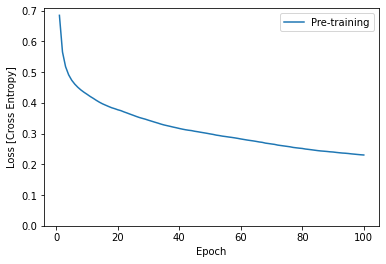

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

참고: 모델을 TensorFlow Lite 형식으로 변환하기 전에 모델의 초기 훈련을 완료해야 모델이 초기 가중치 세트를 갖게 되고, 데이터 수집을 시작하고 기기에서 훈련 실행을 수행하기 *전에* 합리적인 추론을 수행할 수 있습니다.

## 모델을 TensorFlow Lite 형식으로 변환하기

온디바이스 훈련을 위한 추가 기능을 활성화하고 모델의 초기 교육을 완료하도록 TensorFlow 모델을 확장한 후에는 이를 TensorFlow Lite 형식으로 변환할 수 있습니다. 다음 코드는 기기에서 TensorFlow Lite 모델과 함께 사용하는 서명 세트를 포함하여 모델을 해당 형식으로 변환하고 저장합니다(`train, infer, save, restore`).

In [ ]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

### TensorFlow Lite 서명 설정하기

이전 단계에서 저장한 TensorFlow Lite 모델에는 여러 함수 서명이 포함되어 있습니다. `tf.lite.Interpreter` 클래스를 통해 이러한 서명에 액세스하고 각 `restore`, `train`, `save` 및 `infer` 서명을 개별적으로 호출할 수 있습니다.

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

원래 모델의 출력과 변환된 라이트 모델을 비교합니다.

In [ ]:
logits_original = m.infer(x=train_images[:1])['logits'][0]
logits_lite = infer(x=train_images[:1])['logits'][0]

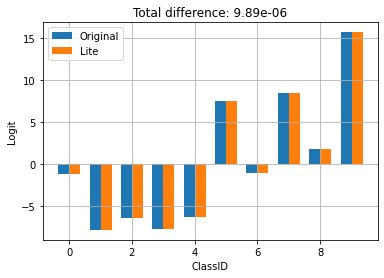

In [ ]:
#@title
def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

compare_logits({'Original': logits_original, 'Lite': logits_lite})

위에서 TFLite로 변환해도 모델의 동작이 바뀌지 않는 것을 볼 수 있습니다.

## 장치에서 모델 다시 훈련하기

모델을 TensorFlow Lite로 변환하고 앱과 함께 배포한 후에는 새 데이터와 모델의 `train` 서명 메서드를 사용하여 장치에서 모델을 다시 훈련할 수 있습니다. 훈련을 실행할 때마다 다음 섹션에 나타낸 바와 같이 모델의 재사용과 추가적인 개선을 위해 저장할 수 있는 새로운 가중치 세트를 생성합니다.

참고: 훈련 작업은 리소스를 많이 사용하므로 사용자가 장치를 많이 사용하지 때 백그라운드 프로세스로 수행하는 것이 좋습니다. [WorkManager](https://developer.android.com/topic/libraries/architecture/workmanager) API를 사용하여 비동기 작업으로 모델 재훈련을 예약하는 것이 효과적입니다.

Android에서는 Java 또는 C++ API를 사용하여 TensorFlow Lite로 장치 내 훈련을 수행할 수 있습니다. Java에서 `Interpreter` 클래스를 사용하여 모델을 로드하고 모델 훈련 작업을 수행합니다. 다음 예제에서는 `runSignature` 메서드를 사용하여 훈련 절차를 실행하는 방법을 보여줍니다.


```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    int NUM_EPOCHS = 100;
    int BATCH_SIZE = 100;
    int IMG_HEIGHT = 28;
    int IMG_WIDTH = 28;
    int NUM_TRAININGS = 60000;
    int NUM_BATCHES = NUM_TRAININGS / BATCH_SIZE;

    List<FloatBuffer> trainImageBatches = new ArrayList<>(NUM_BATCHES);
    List<FloatBuffer> trainLabelBatches = new ArrayList<>(NUM_BATCHES);

    // Prepare training batches.
    for (int i = 0; i < NUM_BATCHES; ++i) {
        FloatBuffer trainImages = FloatBuffer.allocateDirect(BATCH_SIZE * IMG_HEIGHT * IMG_WIDTH).order(ByteOrder.nativeOrder());
        FloatBuffer trainLabels = FloatBuffer.allocateDirect(BATCH_SIZE * 10).order(ByteOrder.nativeOrder());

        // Fill the data values...
        trainImageBatches.add(trainImages.rewind());
        trainImageLabels.add(trainLabels.rewind());
    }

    // Run training for a few steps.
    float[] losses = new float[NUM_EPOCHS];
    for (int epoch = 0; epoch < NUM_EPOCHS; ++epoch) {
        for (int batchIdx = 0; batchIdx < NUM_BATCHES; ++batchIdx) {
            Map<String, Object> inputs = new HashMap<>();
            inputs.put("x", trainImageBatches.get(batchIdx));
            inputs.put("y", trainLabelBatches.get(batchIdx));

            Map<String, Object> outputs = new HashMap<>();
            FloatBuffer loss = FloatBuffer.allocate(1);
            outputs.put("loss", loss);

            interpreter.runSignature(inputs, outputs, "train");

            // Record the last loss.
            if (batchIdx == NUM_BATCHES - 1) losses[epoch] = loss.get(0);
        }

        // Print the loss output for every 10 epochs.
        if ((epoch + 1) % 10 == 0) {
            System.out.println(
              "Finished " + (epoch + 1) + " epochs, current loss: " + loss.get(0));
        }
    }

    // ...
}
```


[모델 개인화 데모 앱](https://github.com/tensorflow/examples/blob/master/lite/examples/model_personalization/android/transfer_api/src/main/java/org/tensorflow/lite/examples/transfer/api/LiteMultipleSignatureModel.java)에서 Android 앱 내부의 모델 재훈련을 위한 전체 코드 예제를 볼 수 있습니다.

몇 번의 epoch 동안 훈련을 실행하여 모델을 개선하거나 개인화합니다. 실제로는 장치에서 수집된 데이터를 사용하여 이 추가 훈련을 실행합니다. 단순화를 위해 이 예제에서는 이전 훈련 단계와 동일한 훈련 데이터를 사용합니다.

In [ ]:
train = interpreter.get_signature_runner("train")

NUM_EPOCHS = 50
BATCH_SIZE = 100
more_epochs = np.arange(epochs[-1]+1, epochs[-1] + NUM_EPOCHS + 1, 1)
more_losses = np.zeros([NUM_EPOCHS])


for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = train(x=x, y=y)
  more_losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {more_losses[i]:.3f}")

Finished 10 epochs
  loss: 0.223
Finished 20 epochs
  loss: 0.216
Finished 30 epochs
  loss: 0.210
Finished 40 epochs
  loss: 0.204
Finished 50 epochs
  loss: 0.198


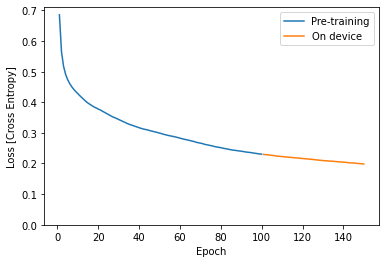

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.plot(more_epochs, more_losses, label='On device')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

위에서 온디바이스 훈련이 사전 교육을 중단한 위치를 정확히 선택하는 것을 볼 수 있습니다.

## 훈련된 가중치 저장하기

장치에서 훈련 실행을 완료하면 모델이 메모리에서 사용 중인 가중치 세트를 업데이트합니다. TensorFlow Lite 모델에서 생성한 `save` 서명 메서드를 사용하여 나중에 재사용하고 모델을 개선하기 위해 이러한 가중치를 체크포인트 파일에 저장할 수 있습니다.

In [ ]:
save = interpreter.get_signature_runner("save")

save(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

{'checkpoint_path': array(b'/tmp/model.ckpt', dtype=object)}

Android 애플리케이션에서 생성된 가중치를 앱에 할당된 내부 저장 공간에 체크포인트 파일로 저장할 수 있습니다.

```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    // Conduct the training jobs.

    // Export the trained weights as a checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map&lt;String, Object&gt; inputs = new HashMap&lt;&gt;();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map&lt;String, Object&gt; outputs = new HashMap&lt;&gt;();
    interpreter.runSignature(inputs, outputs, "save");
}
```

## 훈련된 가중치 복원하기

TFLite 모델에서 인터프리터를 생성할 때마다 인터프리터는 처음에 원래 모델 가중치를 로드합니다.

따라서 일부 훈련을 수행하고 체크포인트 파일을 저장한 후에는 `restore` 서명 메서드를 실행하여 체크포인트를 로드해야 합니다.

"모델에 대한 인터프리터를 생성할 때마다 체크포인트가 있으면 로드하십시오"라는 규칙은 확실히 편리합니다. 모델을 기준 동작으로 재설정해야 하는 경우, 간단히 체크포인트를 삭제하고 새로운 인터프리터를 생성하기만 하면 됩니다.


In [ ]:
another_interpreter = tf.lite.Interpreter(model_content=tflite_model)
another_interpreter.allocate_tensors()

infer = another_interpreter.get_signature_runner("infer")
restore = another_interpreter.get_signature_runner("restore")

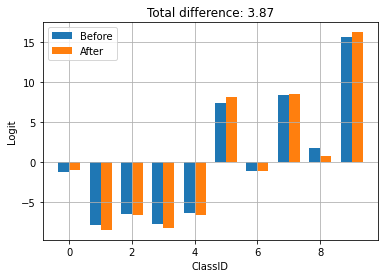

In [ ]:
logits_before = infer(x=train_images[:1])['logits'][0]

# Restore the trained weights from /tmp/model.ckpt
restore(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

logits_after = infer(x=train_images[:1])['logits'][0]

compare_logits({'Before': logits_before, 'After': logits_after})

이 체크포인트는 TFLite로 훈련하고 저장하여 생성합니다. 위에서 체크포인트를 적용하면 모델의 동작이 업데이트됨을 알 수 있습니다.

참고: 모델의 변수 수와 체크포인트 파일의 크기에 따라 체크포인트에서 저장된 가중치를 로드하는 데 시간이 걸릴 수 있습니다.


Android 앱에서 이전에 저장한 체크포인트 파일에서 직렬화되고 훈련된 가중치를 복원할 수 있습니다.

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Load the trained weights from the checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    anotherInterpreter.runSignature(inputs, outputs, "restore");
}
```

참고: 애플리케이션이 다시 시작되면 새로운 추론을 실행하기 전에 훈련된 가중치를 다시 로드해야 합니다.

## 훈련된 가중치를 사용하여 추론 실행하기

체크포인트 파일에서 이전에 저장한 가중치를 로드한 후, `infer` 메서드를 실행하면 예측을 개선하기 위해 원래 모델과 함께 해당 가중치가 사용됩니다. 저장된 가중치를 불러온 후 아래와 같이 `infer` 서명 메서드를 사용할 수 있습니다.

참고: 추론을 실행하는 데 저장된 가중치를 로드할 필요는 없지만 해당 구성에서 실행하면 개선 없이 원래 훈련된 모델을 사용하여 예측이 생성됩니다.

In [ ]:
infer = another_interpreter.get_signature_runner("infer")
result = infer(x=test_images)
predictions = np.argmax(result["output"], axis=1)

true_labels = np.argmax(test_labels, axis=1)

In [ ]:
result['output'].shape

(10000, 10)

예측된 레이블을 플롯합니다.

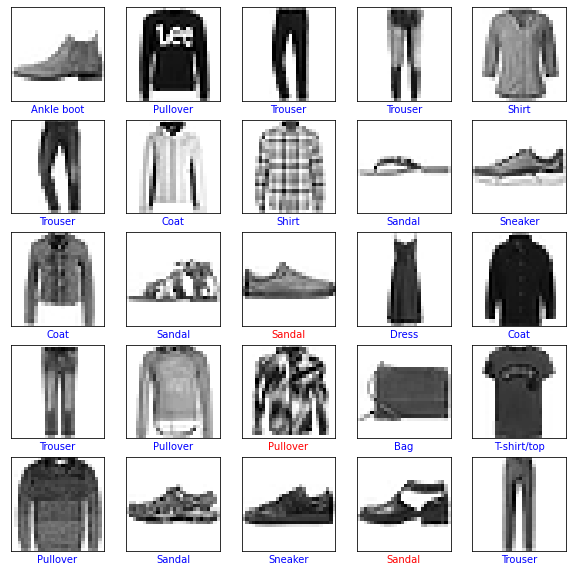

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot(images, predictions, true_labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      color = 'b' if predictions[i] == true_labels[i] else 'r'
      plt.xlabel(class_names[predictions[i]], color=color)
  plt.show()

plot(test_images, predictions, true_labels)

In [ ]:
predictions.shape

(10000,)

Android 애플리케이션에서 훈련된 가중치를 복원한 후, 로드된 데이터를 기반으로 추론을 실행합니다.

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Restore the weights from the checkpoint file.

    int NUM_TESTS = 10;
    FloatBuffer testImages = FloatBuffer.allocateDirect(NUM_TESTS * 28 * 28).order(ByteOrder.nativeOrder());
    FloatBuffer output = FloatBuffer.allocateDirect(NUM_TESTS * 10).order(ByteOrder.nativeOrder());

    // Fill the test data.

    // Run the inference.
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("x", testImages.rewind());
    Map<String, Object> outputs = new HashMap<>();
    outputs.put("output", output);
    anotherInterpreter.runSignature(inputs, outputs, "infer");
    output.rewind();

    // Process the result to get the final category values.
    int[] testLabels = new int[NUM_TESTS];
    for (int i = 0; i < NUM_TESTS; ++i) {
        int index = 0;
        for (int j = 1; j < 10; ++j) {
            if (output.get(i * 10 + index) < output.get(i * 10 + j)) index = testLabels[j];
        }
        testLabels[i] = index;
    }
}
```

축하합니다! 이제 온디바이스 훈련을 지원하는 TensorFlow Lite 모델을 구축했습니다. 자세한 코딩 정보는 [모델 개인화 데모 앱](https://github.com/tensorflow/examples/tree/master/lite/examples/model_personalization)에서 구현 예를 확인하세요.

이미지 분류에 대해 더 알고 싶다면 TensorFlow 공식 가이드 페이지에서 [Keras 분류 튜토리얼](https://www.tensorflow.org/tutorials/keras/classification)을 확인하세요. 이 튜토리얼은 해당 연습을 기반으로 하며 분류 주제에 대해 더 깊은 이해를 제공합니다.
